In [6]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import sys
sys.path.insert(1, '../src/')
from config import raw_data_path, univariate_data_path, processed_data_path

In [8]:
data_file = os.path.join(univariate_data_path, 'merged_univariate.npy')
data = np.load(data_file, allow_pickle=True)
print(data.shape)

# Check for NaN or Inf values in signals
for sample in data:
    if np.isnan(sample['signal']).any() or np.isinf(sample['signal']).any():
        print(f"NaN or Inf detected in {sample['record_name']}")

(666,)


In [3]:
# Function to create sliding windows from a signal
def create_windows(sequence, window_size, step_size):
    windows = [sequence[i:i+window_size] for i in range(0, len(sequence) - window_size + 1, step_size)]
    return np.array(windows)

# Set windowing parameters
window_size = 500  # Length of each window
step_size = 250    # Step size for windowing (overlap)

# Process each record and apply windowing
all_windows = []

for record in data:
    signal = record['signal']  # Extract the signal from the record
    
    # Create windows from the signal
    windows = create_windows(signal, window_size, step_size)
    all_windows.append(windows)

# Convert the list of windows into a numpy array
all_windows = np.concatenate(all_windows, axis=0)

print(all_windows.shape)  # Should print (num_windows, window_size)


(454061, 500)


In [4]:
# Function to mask a percentage of data in each window
def mask_data(windows, mask_percentage=0.2):
    masked_windows = windows.copy()
    num_masked = int(mask_percentage * windows.shape[1])  # Number of values to mask per window
    for i in range(windows.shape[0]):
        mask_indices = np.random.choice(windows.shape[1], num_masked, replace=False)
        masked_windows[i, mask_indices] = np.nan  # Mask with NaN (or 0, depending on choice)
    return masked_windows

# Mask 20% of data in each window
masked_windows = mask_data(all_windows, mask_percentage=0.2)

print(masked_windows.shape)  # Should be same as all_windows: (num_windows, window_size)
masked_windows = np.nan_to_num(masked_windows, nan=0.0)


(454061, 500)


In [5]:
import numpy as np

print("Checking masked_windows...")
print("NaN values:", np.isnan(masked_windows).sum())
print("Inf values:", np.isinf(masked_windows).sum())

print("Checking all_windows...")
print("NaN values:", np.isnan(all_windows).sum())
print("Inf values:", np.isinf(all_windows).sum())


Checking masked_windows...
NaN values: 0
Inf values: 0
Checking all_windows...
NaN values: 0
Inf values: 0


2025-03-10 11:06:02.765520: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741601162.807777 1201944 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741601162.818681 1201944 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-10 11:06:02.908149: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/nwertheim/.local/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alp

Epoch 1/50
6386/6386 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 1.3069 - val_loss: 1.1850
Epoch 2/50
6386/6386 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.0856 - val_loss: 0.3610
Epoch 3/50
6386/6386 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.0465 - val_loss: 0.2082
Epoch 4/50
6386/6386 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.0356 - val_loss: 0.1560
Epoch 5/50
6386/6386 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.0320 - val_loss: 0.1353
Epoch 6/50
6386/6386 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.0295 - val_loss: 0.1161
Epoch 7/50
6386/6386 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.0275 - val_loss: 0.0988
Epoch 8/50
6386/6386 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.0263 - val_loss: 0.0880
Epoch 9/50
6386/6386 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.0248 - val_loss: 0.0855
Epoch 10/50
6386/6386 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.0247 - val_loss: 0.0802
Epoch 11/50
6386/6386 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.0234 - val_loss: 0.0772
Epoch 12/50
6386/63

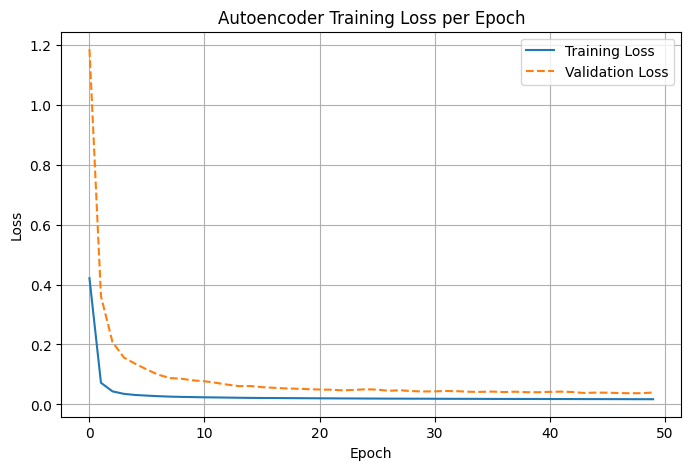

NameError: name 'encoder' is not defined

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

class MaskedAutoencoder(tf.keras.Model):
    def __init__(self, input_dim):
        super(MaskedAutoencoder, self).__init__()

        # Encoder
        self.encoder = models.Sequential([
            layers.Dense(128),
            layers.LeakyReLU(alpha=0.01),
            layers.Dense(64),
            layers.LeakyReLU(alpha=0.01),
        ])

        # Decoder
        self.decoder = models.Sequential([
            layers.Dense(128),
            layers.LeakyReLU(alpha=0.01),
            layers.Dense(input_dim, activation='linear')  # Reconstruct original input
        ])

    def call(self, inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded

# Set input shape
input_dim = 500  # Each window has 500 elements
autoencoder = MaskedAutoencoder(input_dim)

# Use Adam optimizer with lower learning rate and gradient clipping
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0)

autoencoder.compile(optimizer=optimizer, loss='mse')

# Train the model and store history
history = autoencoder.fit(masked_windows, all_windows, epochs=50, batch_size=64, validation_split=0.1)

# Plot loss per epoch
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='dashed')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Autoencoder Training Loss per Epoch')
plt.legend()
plt.grid()
plt.show()
# Save the encoder model


In [7]:
autoencoder.encoder.save("encoder_model.keras")  # Saves in Keras format
print('Saved encoder!')

Saved encoder!
